In [191]:
import json
import re
import random
import openai
import pandas as pd
import re
from nltk.tokenize import sent_tokenize
from pprint import pprint
from pandas import concat
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import collections
import glob
from nltk.tokenize import word_tokenize

In [ ]:
nltk.download('punkt')
!pip install wordcloud

In [150]:
#stockage des mots et des labels dans des listes


with open('challenge.json', 'r') as f:
    contenu = f.read()

codes = json.loads(contenu)

# Extraire les mots et labels de chaque entrée

all_words = []
all_labels=[]
for entry in codes.values():
    words = entry['words']
    all_labels.append(entry['label'])
    for word_list in words:
        all_words.extend(word_list)

In [5]:
#Génération de réponse chatGPT grâce à l'API

openai.api_key = ''

def generate_response(prompt):
    completion = openai.ChatCompletion.create(
        model="gpt-3.5-turbo", 
        messages=[{"role": "user", "content": prompt}]
)

    message = completion['choices'][0]['message']['content']
    return str(message)

In [149]:
#tokenise et filtre les phrases d'un texte avec une liste de mots

def filter_phrases(cr, mots_codes):
    sentences = sent_tokenize(cr)
    phrases_filtrees = []
    for sentence in sentences:
        for mot in mots_codes:
            if "Admission Date:" not in sentence and re.search(r'\b{}\b'.format(mot), sentence.lower()):
                phrases_filtrees.append(sentence.replace('\n', ' '))
                
                break

    return phrases_filtrees

In [7]:
#Création du dataframe codes avec le code le label et la liste de liste de mots du json

code_list = []
label_list = []
words_list = []

for code in codes.keys():
    code_list.append(code)
    values = codes[code]
    label_list.append(values['label'])
    words_list.append(values['words'])

df_dict = {'code': code_list, 'label': label_list, 'words': words_list}


codes = pd.DataFrame(df_dict)

In [61]:
#Création dataframe avec l'effectif des comptes rendus originaux par code  

df=pd.read_csv("labels.csv")
df = df.drop(["Patient_Id", "Admission_Id"], axis=1)
df=df.sum().to_frame()
new_df = pd.DataFrame({'code': df.index, 'effectif': df[0].values}, index=range(len(df)))

In [65]:
#Création dataframe avec l'effectif des comptes rendus originaux par code <100

dfinf=new_df.loc[new_df['effectif'] <100]
dfinf = dfinf.sort_values(by='effectif')
dfinf=dfinf.reset_index(drop=True)
dfinf['code'] = dfinf['code'].str.replace(',', '.')
df_merged = dfinf.merge(codes, on='code', how='left')

In [ ]:
#Généreration des comptes rendus avec l'api ChatGPT et les codes

results = []
generatedata=[]

for i in range(len(df_merged)):
    listemots=[]
    for k in range(len(df_merged['words'][i])):
        for x in range (len(df_merged['words'][i][k])):
            listemots.append(df_merged['words'][i][k][x])
    mots=" ".join(listemots)
    while(df_merged["effectif"][i]<80):
        prompt= "you are cardiologist, give me a medical report with these words "+mots
        result_dict = {'Code': df_merged['code'][i], 'ChatGPT': generate_response(prompt).replace('\n', ' ')}
        results.append(result_dict)
        df_merged["effectif"][i]+=1

generatedata = pd.DataFrame(results)
generatedata.to_csv('generatedata.csv', index=False)

In [349]:
#Concaténation des csv généré par ChatGPT

path = r'C:\Users\zukli\Python\MarathonWeb\GenerateData' 
all_files = glob.glob(path + "/*.csv")

li = []
for filename in all_files:
    generate = pd.read_csv(filename, index_col=None, header=0)
    li.append(generate)

generate = pd.concat(li, axis=0, ignore_index=True)

In [ ]:
generate = generate.rename(columns={"ChatGPT": "full_text"})

In [355]:
#Traitement des csv généré par ChatGPT

generate = pd.crosstab(index=generate['full_text'], columns=generate['Code'])
generate = generate.reset_index().rename_axis(index='Index').reset_index()
generate = generate.drop(columns='Index')

generate33 = pd.crosstab(index=generate33['full_text'], columns=generate33['Code'])
generate33 = generate33.reset_index().rename_axis(index='Index').reset_index()
generate33 = generate33.drop(columns='Index')

generate66 = pd.crosstab(index=generate66['full_text'], columns=generate66['Code'])
generate66 = generate66.reset_index().rename_axis(index='Index').reset_index()
generate66 = generate66.drop(columns='Index')


In [124]:
# Sélection des colonnes à convertir en str
cols_to_convert = generate.columns[1:][generate.iloc[:, 1:].dtypes == float]

# Conversion des noms de colonnes sélectionnées en str
generate.rename(columns={col: str(col) for col in cols_to_convert}, inplace=True)

In [ ]:
sampled_dfs = []
for code, group in generate.groupby('Code'):
    group_size = len(group)
    num_rows = int(group_size / 3)
    sampled_sub_df = group.iloc[:num_rows]
    sampled_dfs.append(sampled_sub_df)

# Concaténer les DataFrames échantillonnés
generate33 = pd.concat(sampled_dfs)
generate33

In [ ]:
sampled_dfs = []
for code, group in generate.groupby('Code'):
    group_size = len(group)
    num_rows = int(group_size *(2/3) )
    sampled_sub_df = group.iloc[:num_rows]
    sampled_dfs.append(sampled_sub_df)

# Concaténer les DataFrames échantillonnés
generate66 = pd.concat(sampled_dfs)
generate66

In [ ]:
for i in range(len(generate33)):
    generate33['full_text'][i]=filter_phrases(generate33['full_text'][i], all_words)
    generate33['full_text'][i]=' '.join(generate33['full_text'][i])
    generate33['full_text'][i]=preprocess(generate33['full_text'][i])


In [ ]:
for i in range(len(generate66)):
    generate66['full_text'][i]=filter_phrases(generate66['full_text'][i], all_words)
    generate66['full_text'][i]=' '.join(generate66['full_text'][i])
    generate66['full_text'][i]=preprocess(generate66['full_text'][i])

In [ ]:
for i in range(len(generate)):
    generate['full_text'][i]=filter_phrases(generate['full_text'][i], all_words)
    generate['full_text'][i]=' '.join(generate['full_text'][i])
    generate['full_text'][i]=preprocess(generate['full_text'][i])

In [ ]:
train_data = pd.read_csv("train_data.csv")
train_data = train_data.drop(train_data.columns[-1], axis=1)

In [363]:
#Concaténation du train avec les données générés

concat33= pd.concat([train_data,generate33], ignore_index=True).fillna(0)
concat66= pd.concat([train_data,generate66], ignore_index=True).fillna(0)
concat= pd.concat([train_data,generate], ignore_index=True).fillna(0)



In [ ]:
new_columns = [train_data.columns[0]] + [float(x) for x in train_data.columns[1:]]
train_data.columns = new_columns
print(train_data.columns)


In [364]:
concat33.columns = [concat33.columns[0]] + concat33.columns[1:].astype(str).tolist()
concat66.columns = [concat66.columns[0]] + concat66.columns[1:].astype(str).tolist()
concat.columns = [concat.columns[0]] + concat.columns[1:].astype(str).tolist()



In [366]:

concat = concat.rename(columns={"414.0": "414.00"})
concat = concat.rename(columns={"420.9": "420.90"})
concat = concat.rename(columns={"412.0": "412"})
concat = concat.rename(columns={"428.3": "428.30"})
concat = concat.rename(columns={"428.2": "428.20"})

concat33 = concat33.rename(columns={"414.0": "414.00"})
concat33 = concat33.rename(columns={"420.9": "420.90"})
concat33 = concat33.rename(columns={"412.0": "412"})
concat33 = concat33.rename(columns={"428.3": "428.30"})
concat33 = concat33.rename(columns={"428.2": "428.20"})

concat66 = concat66.rename(columns={"414.0": "414.00"})
concat66 = concat66.rename(columns={"420.9": "420.90"})
concat66 = concat66.rename(columns={"412.0": "412"})
concat66 = concat66.rename(columns={"428.3": "428.30"})
concat66 = concat66.rename(columns={"428.2": "428.20"})


In [368]:
concat.to_csv('train_data_fullfirst.csv', index=False)
concat33.to_csv('train_data_33first.csv', index=False)
concat66.to_csv('train_data_66first.csv', index=False)


In [31]:
import pandas as pd 
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
import nltk


In [320]:
def preprocess(text):
    # Convertir le texte en minuscule
    text = text.lower()

    # Supprimer les chiffres qui ne sont pas collés à des lettres
    text = re.sub(r'\b\d+\b', '', text)

    # Supprimer la ponctuation
    text = re.sub(r'[^\w\s]|_', '', text)

    # Tokenization des mots
    tokens = word_tokenize(text)

    # Supprimer les stopwords
    tokens = [token for token in tokens if not token in stopwords.words('english')]

    # Lemmatisation des mots
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    # Rejoindre les tokens pour former une chaîne de caractères
    preprocessed_text = ' '.join(tokens)

    return preprocessed_text




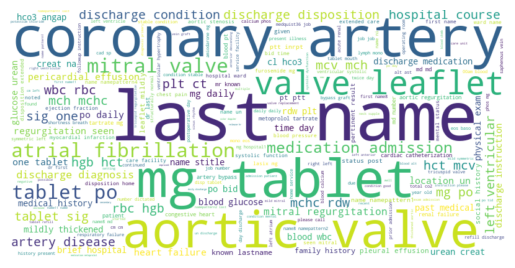

In [55]:
texte = " ".join(train_data["full_text"])

# Créer un nuage de mots
nuage_mot = WordCloud(width=800, height=400, background_color="white").generate(texte)

# Afficher le nuage de mots
plt.imshow(nuage_mot, interpolation="bilinear")
plt.axis("off")
plt.show()

In [ ]:
mots = texte.split()

# Compter le nombre d'occurrences de chaque mot
occurrences = collections.Counter(mots)

# Créer un DataFrame à partir des données
occ=pd.DataFrame(list(occurrences.items()), columns=["Mot", "Occurrence"])
occ = occ.sort_values(by="Occurrence", ascending=False)

# Réinitialiser l'index du DataFrame
occ = occ.reset_index(drop=True)
occ.head(50)

In [230]:
def create_wordcloud(df):
    # Concaténer tous les textes dans une seule chaîne de caractères
    texte = " ".join(df["full_text"])

    # Créer un nuage de mots
    nuage_mot = WordCloud(width=800, height=400, background_color="white").generate(texte)

    # Afficher le nuage de mots
    plt.imshow(nuage_mot)
    plt.axis("off")
    plt.show()


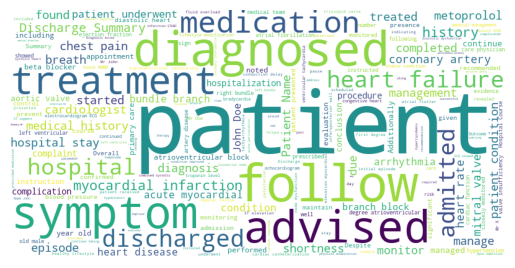

In [233]:
create_wordcloud(generate)

In [193]:
def preprocess(text):

    #custom_stopwords = set(['patient','last name','name','tablet','daily', 'medical', 'discharge','report','mg','symptom','diagnosed','medication','advised','follow','summary']) #Mots ajouter dans le stopwords aprés data viz
    #stop_words = set(stopwords.words('english'))
    #stop_words = stop_words.union(custom_stopwords) 

    # Convertir le texte en minuscule
    text = text.lower()

    # Supprimer les chiffres qui ne sont pas collés à des lettres
    text = re.sub(r'\b\d+\b', '', text)

    # Supprimer la ponctuation
    text = re.sub(r'[^\w\s]|', '', text)

    # Tokenization des mots
    tokens = word_tokenize(text)

    # Supprimer les stopwords
    #tokens = [token for token in tokens if not token in stop_words]

    # Lemmatisation des mots
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    # Rejoindre les tokens pour former une chaîne de caractères
    preprocessed_text = ' '.join(tokens)

    return preprocessed_text



In [132]:
df=pd.read_csv("challenge_filtered.csv")
df = df.drop(columns=[df.columns[0], df.columns[1]])

In [133]:
row_index = 2490  # index de la ligne que vous voulez sélectionner

df_selected  = df.loc[row_index, df.eq(1).any()]



In [134]:
# Afficher le résultat
df_selected=df_selected.to_frame()


In [215]:
import os
import pandas as pd

# Chemin vers le dossier contenant les fichiers texte
chemin_dossier = "C:/Users/zukli/Python/MarathonWeb/text"

fichiers = os.listdir(chemin_dossier)

# Initialisation d'une liste vide pour stocker le contenu des fichiers
contenus = []

# Boucle à travers les fichiers, ouverture et lecture de chaque fichier
for fichier in fichiers:
    chemin_fichier = os.path.join(chemin_dossier, fichier)
    with open(chemin_fichier, "r") as f:
        contenu = f.read()
        contenus.append(contenu)

# Créer un DataFrame avec le contenu des fichiers
dft = pd.DataFrame({"contenu": contenus})

In [216]:
df = pd.concat([dft, dfg], axis=1)

In [217]:
df.columns = ['text', 'textg']


In [137]:
df['gender'].iloc[row_index]

'F'

In [138]:
df['age'].iloc[row_index]

86.0

In [139]:
df['ethnicity'].iloc[row_index]

'WHITE'

In [219]:
for i in range(len(df)):
    df['textg'][i]=filter_phrases(df['textg'][i], all_words)
    

In [232]:
df['text'][0]=preprocess(df['text'][0])
df['text'][1]=preprocess(df['text'][1])
df['text'][2]=preprocess(df['text'][2])
df['text'][3]=preprocess(df['text'][3])
df['text'][4]=preprocess(df['text'][4])

df['textg'][0]=preprocess(df['textg'][0])
df['textg'][1]=preprocess(df['textg'][1])
df['textg'][2]=preprocess(df['textg'][2])
df['textg'][3]=preprocess(df['textg'][3])
df['textg'][4]=preprocess(df['textg'][4])

In [228]:
df['textg'][0]=my_str = ' '.join(df['textg'][0])


In [267]:
def create_wordcloud(text):
    # Concaténer tous les textes dans une seule chaîne de caractères

    # Créer un nuage de mots
    nuage_mot = WordCloud(width=800, height=400, background_color="white").generate(text)

    # Afficher le nuage de mots
    plt.imshow(nuage_mot)
    plt.axis("off")
    plt.show()

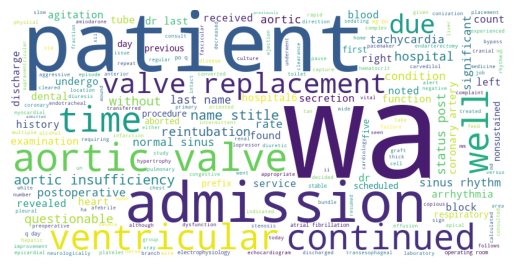

In [270]:
create_wordcloud(df['text'][1])

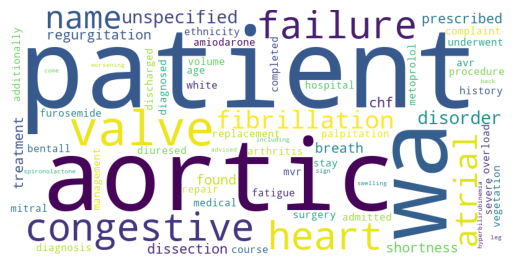

In [271]:
create_wordcloud(df['textg'][1])

In [196]:
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
import nltk

In [174]:
def preprocess(text):
    # Convertir le texte en minuscule
    text = text.lower()
    
    # Supprimer les chiffres qui ne sont pas collés à des lettres
    text = re.sub(r'\b\d+\b', '', text)
    
    # Supprimer la ponctuation
    text = re.sub(r'[^\w\s]|_', '', text)
    
    # Tokenization des mots
    tokens = word_tokenize(text)
    
    # Supprimer les stopwords
    tokens = [token for token in tokens if not token in stopwords.words('english')]
    
    # Lemmatisation des mots
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    
    # Rejoindre les tokens pour former une chaîne de caractères
    preprocessed_text = ' '.join(tokens)
    
    return preprocessed_text

In [236]:
from nltk.translate.bleu_score import corpus_bleu
from rouge import Rouge